# Evaluate perplexity

In [66]:
# Imports

import os, logging, argparse, sys

import torch

from hyformer.configs.dataset import DatasetConfig
from hyformer.configs.tokenizer import TokenizerConfig
from hyformer.configs.model import ModelConfig
from hyformer.configs.trainer import TrainerConfig

from hyformer.utils.datasets.sequence import SequenceDataset
from hyformer.utils.datasets.auto import AutoDataset
from hyformer.utils.tokenizers.auto import AutoTokenizer
from hyformer.models.auto import AutoModel


from hyformer.trainers.trainer import Trainer

from hyformer.utils.experiments import log_args, dump_configs
from hyformer.utils.reproducibility import set_seed

import pandas as pd
import numpy as np
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# autoreload
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
DATA_DIR = "/lustre/groups/aih/hyformer/data"

DATASET_CONFIG_PATH = "configs/datasets/guacamol/config.json"
TOKENIZER_CONFIG_PATH = "configs/tokenizers/smiles/config.json"
MODEL_CONFIG_PATH = "configs/models/hyformer_small/config.json"
TRAINER_CONFIG_PATH = "configs/trainers/distribution_learning/guacamol/lm/config.json"

MODEL_CKPT_PATH = "/lustre/groups/aih/hyformer/results/distribution_learning/guacamol/hyformer_small/lm_enumerated/checkpoint.pt"
NON_TEST_DATA_PATH = "/lustre/groups/aih/hyformer/data/moses/raw/test_scaffolds.csv"


In [68]:
# Load configurations
dataset_config = DatasetConfig.from_config_filepath(DATASET_CONFIG_PATH)
tokenizer_config = TokenizerConfig.from_config_filepath(TOKENIZER_CONFIG_PATH)
model_config = ModelConfig.from_config_filepath(MODEL_CONFIG_PATH)
trainer_config = TrainerConfig.from_config_filepath(TRAINER_CONFIG_PATH)


In [92]:
# Load non-test data

non_test_data = pd.read_csv(NON_TEST_DATA_PATH)['SMILES'].tolist()


# non_test_data = [
#     # Long hydrocarbon chains and extremely lipophilic structures
#     "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC",
#     "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC",
#     "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC",
#     "CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC",
    
#     # Highly branched structures
#     "CC(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)C(C)(C)",
#     "CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)CC(C)(C)",
#     "CCC(CC)(CC)CCC(CC)(CC)CCC(CC)(CC)CCC(CC)(CC)CCC(CC)(CC)CCC(CC)(CC)",
#     "CCC(CCC)(CCC)CCC(CCC)(CCC)CCC(CCC)(CCC)CCC(CCC)(CCC)CCC(CCC)(CCC)",
    
#     # Multiple fused cyclic structures
#     "C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1",
#     "C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1C1CCCCC1",
#     "C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)",
#     "C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)C1CCC(CC1)",
    
#     # Multiple connected aromatic systems
#     "C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)",
#     "C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)",
#     "C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)",
#     "C1=CC=C(C=C1)C2=CC=CC=C2C3=CC=CC=C3C4=CC=CC=C4C5=CC=CC=C5C6=CC=CC=C6",
    
#     # Combinations of aromatic systems and long chains
#     "CCCCCCCCCC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1",
#     "CCCCCCCCCCCCCCCC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1",
#     "CCCCC1=CC=C(CCCCCCC2=CC=C(CCCCCCC3=CC=C(CCCCCCC4=CC=CC=C4)C=C3)C=C2)C=C1",
#     "CCCCCCCCC1=CC=C(CCCCCCCC2=CC=C(CCCCCCCC3=CC=C(CCCCCCCC4=CC=CC=C4)C=C3)C=C2)C=C1",
    
#     # Structures with multiple sulfones
#     "C1=CC=C(C=C1)S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1",
#     "C1=CC=C(C=C1)S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1S(=O)(=O)C1=CC=CC=C1",
#     "CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CCS(=O)(=O)CC",
#     "CS(=O)(=O)C1=CC=C(S(=O)(=O)C2=CC=C(S(=O)(=O)C3=CC=C(S(=O)(=O)C)C=C3)C=C2)C=C1",
    
#     # Highly fluorinated/silylated compounds
#     "C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C1=CC=C(C=C1)C(F)(F)F",
#     "FC(F)(F)C1=CC=C(C(F)(F)F)C=C1C1=CC=C(C(F)(F)F)C=C1C1=CC=C(C(F)(F)F)C=C1",
#     "C1=CC=C(C=C1)C(F)(F)F(F)(F)F(F)(F)F(F)(F)F(F)(F)F(F)(F)F(F)(F)F",
#     "C[Si](C)(C)C[Si](C)(C)C[Si](C)(C)C[Si](C)(C)C[Si](C)(C)C[Si](C)(C)C[Si](C)(C)C",
    
#     # Complex cyclic structures with multiple substituents
#     "C1CC(CCC2CCCCC2)C(CCC2CCCCC2)C(CCC2CCCCC2)C(CCC2CCCCC2)C1",
#     "C1CC(CCC2CCCCC2)C(CCC2CCCCC2)C(CCC2CCCCC2)C(CCC2CCCCC2)C(CCC2CCCCC2)C1",
#     "C1CC(C(C)C)C(C(C)C)C(C(C)C)C(C(C)C)C(C(C)C)C(C(C)C)C(C(C)C)C1",
#     "C1CC(C(C)(C)C)C(C(C)(C)C)C(C(C)(C)C)C(C(C)(C)C)C(C(C)(C)C)C(C(C)(C)C)C1",
    
#     # Combinations with heavy halogen substituents
#     "BrC1=CC=C(Br)C=C1C1=CC=C(Br)C=C1C1=CC=C(Br)C=C1C1=CC=C(Br)C=C1",
#     "BrC1=CC(Br)=CC(Br)=C1C1=C(Br)C(Br)=C(Br)C(Br)=C1C1=C(Br)C(Br)=C(Br)C(Br)=C1",
#     "IC1=CC=C(I)C=C1C1=CC=C(I)C=C1C1=CC=C(I)C=C1C1=CC=C(I)C=C1",
#     "ClC1=CC(Cl)=CC(Cl)=C1C1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1C1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1",
    
#     # More long alkylated aromatics
#     "CCCCCCCCC1=CC=C(CCCCCCCCC)C=C1C1=CC=C(CCCCCCCCC)C=C1",
#     "CCCCCCCCCC1=CC=C(CCCCCCCCCC)C=C1C1=CC=C(CCCCCCCCCC)C=C1",
#     "CCCCCCC1=CC=C(CCCCCCC)C=C1CCCCCCC1=CC=C(CCCCCCC)C=C1",
#     "CCCCCCCC1=CC=C(CCCCCCCC)C=C1CCCCCCCC1=CC=C(CCCCCCCC)C=C1",
    
#     # Fused ring systems
#     "C1CCC2CCCCC2C1C1CCC2CCCCC2C1C1CCC2CCCCC2C1C1CCC2CCCCC2C1",
#     "C1CCC2CCCCC2C1C1CCC2CCCCC2C1C1CCC2CCCCC2C1C1CCC2CCCCC2C1C1CCC2CCCCC2C1",
#     "C1CC2CCCCC2C1C1CC2CCCCC2C1C1CC2CCCCC2C1C1CC2CCCCC2C1C1CC2CCCCC2C1",
#     "C1CCC2CCCC3CCCC4CCCCC4C3C2C1C1CCC2CCCC3CCCC4CCCCC4C3C2C1",
    
#     # Bridged polycyclic systems
#     "C12CC3CC(CC(C3)C1)C2C12CC3CC(CC(C3)C1)C2C12CC3CC(CC(C3)C1)C2",
#     "C12CC3CC(CC(C3)C1)C2C12CC3CC(CC(C3)C1)C2C12CC3CC(CC(C3)C1)C2C12CC3CC(CC(C3)C1)C2",
#     "C12CC3CC(CC(C3)C1)C2C45CC6CC(CC(C6)C4)C5C78CC9CC(CC(C9)C7)C8",
#     "C1CC2CCC1C2C1CC2CCC1C2C1CC2CCC1C2C1CC2CCC1C2C1CC2CCC1C2",
    
#     # Long ethers
#     "CCCCCCCCCOCCCCCCCCCOCCCCCCCCCOCCCCCCCCCOCCCCCCCCC",
#     "CCCCCCCOCCCCCCCOCCCCCCCOCCCCCCCOCCCCCCCOCCCCCCC",
#     "CCCCCOCCCCCCOCCCCCOCCCCCOCCCCCCOCCCCCOCCCCC",
#     "CCCCCCOCCCCCCOCCCCCCOCCCCCCOCCCCCCOCCCCCCO",
    
#     # Polycyclic systems with heteroatoms
#     "C1CC(CCC2CCCOC2)C(CCC2CCCOC2)C(CCC2CCCOC2)C(CCC2CCCOC2)C1",
#     "C1CC(CCC2CCCSC2)C(CCC2CCCSC2)C(CCC2CCCSC2)C(CCC2CCCSC2)C1",
#     "C1CC(CCC2CCCNC2)C(CCC2CCCNC2)C(CCC2CCCNC2)C(CCC2CCCNC2)C1",
#     "C1CC(CCC2CCCC=C2)C(CCC2CCCC=C2)C(CCC2CCCC=C2)C(CCC2CCCC=C2)C1",
    
#     # Multiple long chain substituents
#     "CCCCCCC(CCCCCCC)(CCCCCCC)CCCCCCC(CCCCCCC)(CCCCCCC)CCCCCCC",
#     "CCCCCC(CCCCCC)(CCCCCC)CCCCCC(CCCCCC)(CCCCCC)CCCCCC",
#     "CCCCC(CCCCC)(CCCCC)CCCCC(CCCCC)(CCCCC)CCCCC(CCCCC)(CCCCC)CCCCC",
#     "CCCC(CCCC)(CCCC)CCCC(CCCC)(CCCC)CCCC(CCCC)(CCCC)CCCC(CCCC)(CCCC)CCCC",
    
#     # Long chains with esters
#     "CCCCCCCCCOC(=O)CCCCCCCCOC(=O)CCCCCCCCOC(=O)CCCCCCCCO",
#     "CCCCCCOC(=O)CCCCCCOC(=O)CCCCCCOC(=O)CCCCCCOC(=O)CCCCCC",
#     "CCCCCOC(=O)CCCCCOC(=O)CCCCCOC(=O)CCCCCOC(=O)CCCCCOC(=O)CCCCC",
#     "CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCCOC(=O)CCCC",
    
#     # Highly substituted aromatics
#     "CC(C)(C)C1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1C1=C(C(C)(C)C)C(C(C)(C)C)=C(C(C)(C)C)C=C1",
#     "CC(C)(C)C1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1C1=C(C(C)(C)C)C(C(C)(C)C)=C(C(C)(C)C)C=C1C1=C(C(C)(C)C)C=C(C(C)(C)C)C(C(C)(C)C)=C1",
#     "CCCC1=CC(CCCC)=CC(CCCC)=C1C1=C(CCCC)C(CCCC)=C(CCCC)C=C1C1=C(CCCC)C=C(CCCC)C(CCCC)=C1",
#     "CCCCCC1=CC(CCCCCC)=CC(CCCCCC)=C1C1=C(CCCCCC)C(CCCCCC)=C(CCCCCC)C=C1",
    
#     # Spirocyclic systems
#     "C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1",
#     "C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1C1CCC2(CCCCC2)CC1",
#     "C1CCC2(CCCCC2(CCCCC2))CC1C1CCC2(CCCCC2(CCCCC2))CC1C1CCC2(CCCCC2(CCCCC2))CC1",
#     "C1CC2(CCC1)CCCC2C1CC2(CCC1)CCCC2C1CC2(CCC1)CCCC2C1CC2(CCC1)CCCC2",
    
#     # Combinations with long alkoxy groups
#     "CCCCCCCOC1=CC=C(OCCCCCC)C=C1C1=CC=C(OCCCCCC)C=C1C1=CC=C(OCCCCCC)C=C1",
#     "CCCCCCCCOC1=CC=C(OCCCCCCC)C=C1C1=CC=C(OCCCCCCC)C=C1C1=CC=C(OCCCCCCC)C=C1",
#     "CCCCCCCCCOC1=CC=C(OCCCCCCCC)C=C1C1=CC=C(OCCCCCCCC)C=C1C1=CC=C(OCCCCCCCC)C=C1",
#     "CCCCCCCCCCOC1=CC=C(OCCCCCCCCC)C=C1C1=CC=C(OCCCCCCCCC)C=C1",
    
#     # Highly alkylated nitrogen compounds
#     "CCCCN(CCCC)CCCCN(CCCC)CCCCN(CCCC)CCCCN(CCCC)CCCC",
#     "CCCCCN(CCCCC)CCCCCN(CCCCC)CCCCCN(CCCCC)CCCCCN(CCCCC)CCCCC",
#     "CCCCCCN(CCCCCC)CCCCCCN(CCCCCC)CCCCCCN(CCCCCC)CCCCCC",
#     "CCCCCCCN(CCCCCCC)CCCCCCCN(CCCCCCC)CCCCCCCN(CCCCCCC)CCCCCCC",
    
#     # Compounds with multiple phosphate groups
#     "COP(=O)(OC)OP(=O)(OC)OP(=O)(OC)OP(=O)(OC)OP(=O)(OC)OP(=O)(OC)OC",
#     "CCOP(=O)(OCC)OP(=O)(OCC)OP(=O)(OCC)OP(=O)(OCC)OP(=O)(OCC)OCC",
#     "CCCOP(=O)(OCCC)OP(=O)(OCCC)OP(=O)(OCCC)OP(=O)(OCCC)OCCC",
#     "CCCCOP(=O)(OCCCC)OP(=O)(OCCCC)OP(=O)(OCCCC)OP(=O)(OCCCC)OCCCC",
    
#     # Long siloxanes
#     "C[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C",
#     "CC[Si](CC)(CC)O[Si](CC)(CC)O[Si](CC)(CC)O[Si](CC)(CC)O[Si](CC)(CC)CC",
#     "CCC[Si](CCC)(CCC)O[Si](CCC)(CCC)O[Si](CCC)(CCC)O[Si](CCC)(CCC)CCC",
#     "CCCC[Si](CCCC)(CCCC)O[Si](CCCC)(CCCC)O[Si](CCCC)(CCCC)CCCC",
    
#     # Additional highly hydrophobic structures with non-drug-like features
#     "CCCCCCCCC=CCCCCCCCC=CCCCCCCCC=CCCCCCCCC",
#     "CCCCCCCC#CCCCCCCCC#CCCCCCCCC#CCCCCCCC",
#     "CCCCCCCI.CCCCCCCI.CCCCCCCI.CCCCCCCI",
#     "CCCCCCCCB(OCCCCCCC)OCCCCCCCB(OCCCCCCC)OCCCCCCC"
# ]

In [93]:
# Initialize
train_dataset = AutoDataset.from_config(dataset_config, split='train', root=DATA_DIR)
test_dataset = AutoDataset.from_config(dataset_config, split='test', root=DATA_DIR)
non_test_dataset = SequenceDataset(data=non_test_data)
tokenizer = AutoTokenizer.from_config(tokenizer_config)
model = AutoModel.from_config(model_config)
model.load_pretrained(MODEL_CKPT_PATH)
   

In [94]:
# Determine the device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')


In [95]:
# Initialize trainer
trainer = Trainer(
    config=trainer_config,
    model=model,
    tokenizer=tokenizer,
    device=device,
    )



In [96]:
train_loader = trainer.create_loader(train_dataset, tasks={'lm': 1}, shuffle=False, num_workers=8)
test_loader = trainer.create_loader(test_dataset, tasks={'lm': 1}, shuffle=False, num_workers=8)
non_test_loader = trainer.create_loader(non_test_dataset, tasks={'lm': 1}, shuffle=False, num_workers=8)

In [97]:
_special_token_ids = [tokenizer.task_token_id('lm'), tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.pad_token_id]

In [98]:
def calculate_perplexity(logits, target, special_token_ids=None, shift_logits=True, ignore_index=-100):
    """
    Calculate perplexity for a given logits and target.

    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size], logits from the model.
        target: Tensor of shape [batch_size, seq_len], target token IDs.
        special_token_ids: List of token IDs to ignore in perplexity (e.g., [pad_id, bos_id]).
        shift_logits: Whether to shift logits by one position (default: True).

    Returns:
        Tensor of shape [batch_size] with perplexity per sample.
    """
    
    if shift_logits:
        logits = logits[:, :-1, :]
        target = target[:, 1:]
        
    if ignore_index is not None and special_token_ids is not None:        
        for token_id in special_token_ids:
            target = target.where(target != token_id, ignore_index)

    if ignore_index is not None:
        mask = (target != ignore_index).unsqueeze(-1).expand(logits.size())
        logits = logits.masked_fill(~mask, float('-inf'))
        
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Calculate perplexity for each sequence in the batch
    batch_size = logits.size(0)
    perplexities = []
    
    # Loop over batch - this part can't be fully vectorized
    # because each sequence may have different numbers of valid tokens
    for idx in range(batch_size):
        # Filter out ignored tokens
        _valid_mask = target[idx] != ignore_index
        _log_probs = log_probs[idx][_valid_mask]  # [num_valid, vocab_size]
        _targets = target[idx][_valid_mask]  # [num_valid]
        
        if len(_targets) == 0:
            # Handle empty case
            perplexities.append(torch.tensor(1.0))
            continue
            
        # Get log probabilities for targets
        token_log_probs = _log_probs.gather(1, _targets.unsqueeze(1)).squeeze(1)
        
        # Calculate average negative log likelihood
        avg_nll = -token_log_probs.mean()
        
        # Calculate perplexity
        perplexities.append(torch.exp(avg_nll))
    
    # Stack results
    return torch.stack(perplexities)


In [105]:
model.eval()
model.to(device)

loader = test_loader
dataset = test_dataset
test_perplexity = np.zeros((len(dataset), ), dtype=np.float32)
with torch.no_grad():       
    for _idx, _batch in tqdm(enumerate(loader), total=len(loader)):
        _batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in _batch.items()}
        _outputs = model(**_batch)
        _logits = _outputs['logits'].detach().cpu()
        _input_labels = _batch['input_labels'].detach().cpu()
        _perplexity = calculate_batch_perplexities(_logits, _input_labels, shift_logits=True, ignore_index=-100)
        test_perplexity[_idx * trainer.config.batch_size:(_idx + 1) * trainer.config.batch_size] = _perplexity.detach().cpu().numpy()

  0%|          | 0/234 [00:00<?, ?it/s]

In [106]:
model.eval()
model.to(device)

loader = non_test_loader
dataset = non_test_dataset
non_test_perplexity = np.zeros((len(dataset), ), dtype=np.float32)
with torch.no_grad():       
    for _idx, _batch in tqdm(enumerate(loader), total=len(loader)):
        _batch = {k:v.to(device) if isinstance(v, torch.Tensor) else v for k,v in _batch.items()}
        _outputs = model(**_batch)
        _logits = _outputs['logits'].detach().cpu()
        _input_labels = _batch['input_labels'].detach().cpu()
        _perplexity = calculate_batch_perplexities(_logits, _input_labels, shift_logits=True, ignore_index=-100)
        non_test_perplexity[_idx * trainer.config.batch_size:(_idx + 1) * trainer.config.batch_size] = _perplexity.detach().cpu().numpy()

  0%|          | 0/173 [00:00<?, ?it/s]

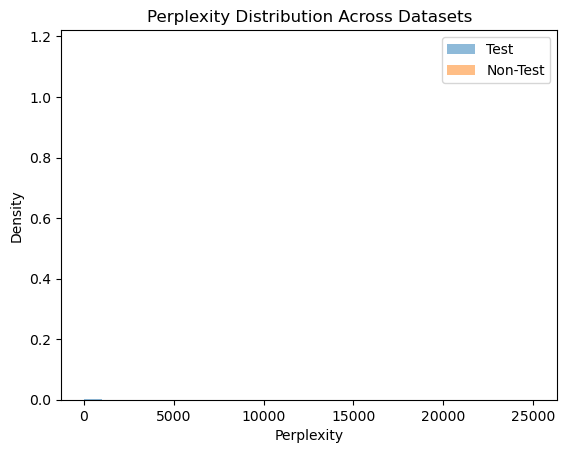

In [107]:
# plt.hist(train_perplexity, bins=100, alpha=0.5, label='Train', density=True)
plt.hist(test_perplexity, bins=25, alpha=0.5, label='Test', density=True)
plt.hist(non_test_perplexity, bins=25, alpha=0.5, label='Non-Test', density=True)
plt.xlabel('Perplexity')
plt.ylabel('Density')
plt.title('Perplexity Distribution Across Datasets')
plt.legend()
plt.show()


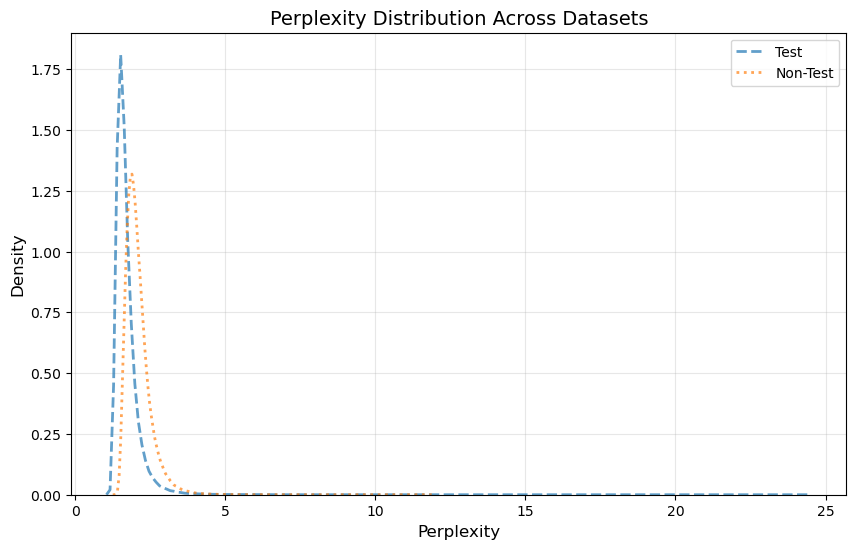

In [109]:

# Plot perplexity distributions with KDE to make overlapping lines more visible
import seaborn as sns

# Using KDE plots for better visibility of overlapping distributions
plt.figure(figsize=(10, 6))
# sns.kdeplot(train_perplexity, label='Train', linewidth=2, alpha=0.7)
sns.kdeplot(test_perplexity[test_perplexity < 25], label='Test', linewidth=2, alpha=0.7, linestyle='--')
sns.kdeplot(non_test_perplexity[non_test_perplexity < 25], label='Non-Test', linewidth=2, alpha=0.7, linestyle=':')

plt.xlabel('Perplexity', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Perplexity Distribution Across Datasets', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


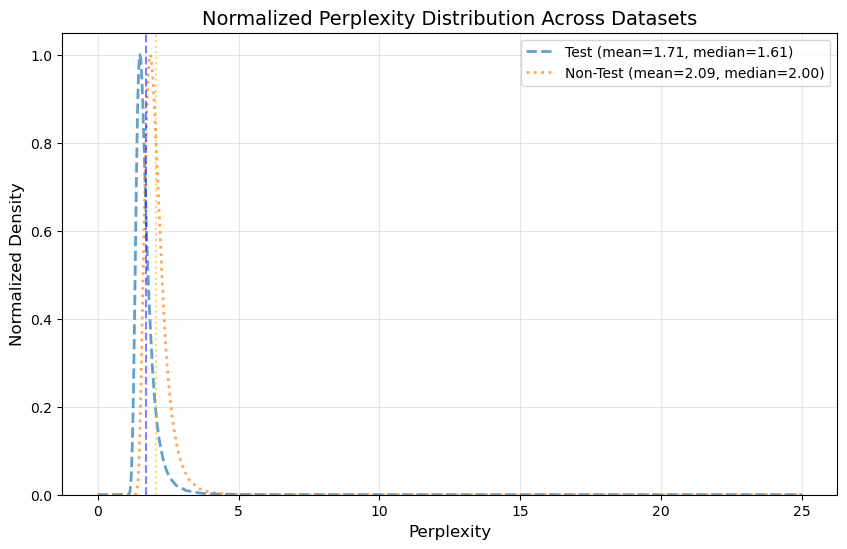

In [110]:
# Plot perplexity distributions with KDE, normalizing each density separately
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.figure(figsize=(10, 6))

# Create separate KDE for each distribution, normalized independently
# For test perplexity
test_data = test_perplexity[test_perplexity < 25]
test_kde = stats.gaussian_kde(test_data)
test_x = np.linspace(0, 25, 1000)
test_y = test_kde(test_x)
test_y = test_y / test_y.max()  # Normalize to max height of 1

# For non-test perplexity
non_test_data = non_test_perplexity[non_test_perplexity < 25]
non_test_kde = stats.gaussian_kde(non_test_data)
non_test_x = np.linspace(0, 25, 1000)
non_test_y = non_test_kde(non_test_x)
non_test_y = non_test_y / non_test_y.max()  # Normalize to max height of 1

# Plot the normalized densities
plt.plot(test_x, test_y, label='Test', linewidth=2, alpha=0.7, linestyle='--')
plt.plot(non_test_x, non_test_y, label='Non-Test', linewidth=2, alpha=0.7, linestyle=':')

# Add statistics to legend
test_mean = test_data.mean()
non_test_mean = non_test_data.mean()
test_median = np.median(test_data)
non_test_median = np.median(non_test_data)

plt.legend([
    f'Test (mean={test_mean:.2f}, median={test_median:.2f})',
    f'Non-Test (mean={non_test_mean:.2f}, median={non_test_median:.2f})'
], fontsize=10)

plt.xlabel('Perplexity', fontsize=12)
plt.ylabel('Normalized Density', fontsize=12)
plt.title('Normalized Perplexity Distribution Across Datasets', fontsize=14)
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)  # Set y-axis from 0 to just above 1

# Add vertical lines for mean values
plt.axvline(x=test_mean, color='blue', linestyle='--', alpha=0.5)
plt.axvline(x=non_test_mean, color='orange', linestyle=':', alpha=0.5)

plt.show()

In [83]:
non_test_perplexity.mean()

3.9403412

In [ ]:
def calculate_perplexity_stable(logits: torch.Tensor, 
                               target: torch.Tensor, 
                               ignore_index: int = -100,
                               special_token_ids: Optional[List[int]] = None,
                               shift_logits: bool = True,
                               eps: float = 1e-10) -> torch.Tensor:
    """
    Calculate perplexity with improved numerical stability.
    
    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size] containing model logits
        target: Tensor of shape [batch_size, seq_len] containing token IDs
        ignore_index: Token ID to ignore (default: -100)
        special_token_ids: List of special token IDs to ignore
        shift_logits: Whether to shift logits and targets for causal LM
        eps: Small value to add for numerical stability
        
    Returns:
        Perplexity tensor of shape [batch_size, 1]
    """
    # Shift logits and targets for causal language modeling
    if shift_logits:
        logits = logits[:, :-1, :]
        target = target[:, 1:]
        
    # Mask special tokens
    if ignore_index is not None and special_token_ids is not None:        
        for token_id in special_token_ids:
            target = target.where(target != token_id, ignore_index)

    # Create a mask for valid tokens
    valid_mask = (target != ignore_index)
    
    # Compute valid token counts per sequence (for proper averaging later)
    token_counts = valid_mask.sum(dim=1).clamp(min=1)  # [batch_size]
    
    # Calculate log probabilities with stable log_softmax
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Create safe target tensor - replace ignore_index with a safe value
    # We'll use the first token ID (0) and mask it out later
    safe_target = target.clone()
    safe_target[~valid_mask] = 0
    
    # Gather log probs
    indices = safe_target.unsqueeze(-1)
    token_log_probs = log_probs.gather(2, indices).squeeze(-1)  # [batch_size, seq_len]
    
    # Apply mask - invalid positions contribute 0 to the sum
    # (instead of using NaN which can cause issues)
    masked_log_probs = token_log_probs * valid_mask.float()
    
    # Sum log probs and divide by token counts for each sequence
    # This is equivalent to taking the mean but more stable
    sum_log_probs = masked_log_probs.sum(dim=1)  # [batch_size]
    avg_nll = -sum_log_probs / token_counts.float()  # [batch_size]
    
    # Calculate perplexity with clipping to avoid numerical issues
    # Clip extremely negative values to avoid huge perplexity
    avg_nll = torch.clamp(avg_nll, max=100)  # Limit max perplexity to exp(100)
    perplexity = torch.exp(avg_nll)
    
    # Handle empty sequences explicitly
    empty_sequences = (token_counts == 0)
    perplexity = torch.where(empty_sequences, 
                             torch.ones_like(perplexity),
                             perplexity)
    
    return perplexity.unsqueeze(1)

In [ ]:
# Calculate loss for each sample separately
sample_losses = []
for i in range(batch_size):
    # Get valid tokens for this sample
    valid_indices = targets[i] != ignore_index
    if valid_indices.sum() == 0:
        sample_losses.append(torch.tensor(0.0))
        continue
        
    # Calculate average loss for this sample
    sample_logits = logits[i, valid_indices]
    sample_targets = targets[i, valid_indices]
    sample_loss = criterion(sample_logits, sample_targets)
    sample_losses.append(sample_loss)
    
# Convert to sample perplexities
perplexities = [torch.exp(loss) for loss in sample_losses]

In [101]:
def calculate_per_sample_perplexity_standardized(logits, targets, ignore_index=-100):
    """
    Calculate per-sample perplexity from logits and targets.
    
    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size]
        targets: Tensor of shape [batch_size, seq_len]
        ignore_index: Index to ignore (padding, special tokens)
        
    Returns:
        Tensor of shape [batch_size] with per-sample perplexity
    """
    # Calculate token-level loss (no reduction)
    batch_size, seq_len, vocab_size = logits.size()
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)
    
    # Reshape for crossentropy
    flat_logits = logits.view(-1, vocab_size)
    flat_targets = targets.view(-1)
    
    # Get token-level losses
    token_losses = loss_fn(flat_logits, flat_targets)
    
    # Reshape back to [batch_size, seq_len]
    token_losses = token_losses.view(batch_size, seq_len)
    
    # Create a mask for valid (non-ignored) tokens
    mask = (targets != ignore_index).float()
    
    # Calculate per-sample average loss
    # Sum losses and divide by token counts
    sample_token_counts = mask.sum(dim=1).clamp(min=1)  # Avoid divide by zero
    sample_total_loss = (token_losses * mask).sum(dim=1)
    sample_avg_loss = sample_total_loss / sample_token_counts
    
    # Calculate per-sample perplexity
    return torch.exp(sample_avg_loss)

In [102]:
def calculate_per_sample_perplexity(logits, targets, ignore_index=-100, max_loss=30.0, shift=True):
    """
    Calculate differentiable per-sample perplexity with proper shifting for causal language modeling.
    
    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size]
        targets: Tensor of shape [batch_size, seq_len]
        ignore_index: Index to ignore (padding, special tokens)
        max_loss: Maximum loss value to prevent extremely large perplexity
        shift: Whether to shift logits and targets for causal LM (next token prediction)
        
    Returns:
        Tensor of shape [batch_size] with per-sample perplexity (differentiable)
    """
    
    if shift:
        # Shift logits and targets to align predictions with targets
        shifted_logits = logits[:, :-1, :]  # Remove last position
        shifted_targets = targets[:, 1:]    # Remove first position
    else:
        shifted_logits = logits
        shifted_targets = targets
    
    # Apply log_softmax - differentiable operation
    log_probs = F.log_softmax(shifted_logits, dim=-1)
    
    batch_size, seq_len, vocab_size = shifted_logits.size()
    
    # Create a mask for valid (non-ignored) tokens
    # detach mask as we don't need gradients for it
    mask = (shifted_targets != ignore_index).float().detach()
    
    # Get per-token losses (negative log probabilities)
    # gather maintains gradient flow
    token_log_probs = torch.gather(
        log_probs, 
        dim=2, 
        index=shifted_targets.unsqueeze(2)
    ).squeeze(2)
    
    # Replace invalid values with zeros in a differentiable way
    # Use mask multiplication instead of masked_fill for gradient flow
    token_log_probs = token_log_probs * mask
    
    # Calculate per-sample loss (negative log likelihood)
    token_counts = mask.sum(dim=1).clamp(min=1)  # detached
    total_log_probs = token_log_probs.sum(dim=1)
    avg_loss = -total_log_probs / token_counts
    
    # Clip loss in a differentiable way
    avg_loss = torch.min(
        avg_loss, 
        torch.full_like(avg_loss, max_loss)
    )
    
    # Calculate perplexity - exp is differentiable
    perplexity = torch.exp(avg_loss)
    
    # Handle edge cases while maintaining gradients where possible
    # Create a baseline tensor of ones (no gradients needed)
    ones = torch.ones_like(perplexity).detach()
    
    # Create differentiable masks for valid samples
    valid_samples = (token_counts > 0).float().detach()
    
    # Combine with a differentiable operation
    # perplexity * valid_samples + ones * (1 - valid_samples)
    perplexity = perplexity * valid_samples + ones * (1 - valid_samples)
    
    return perplexity

In [ ]:
def calculate_perplexity_differentiable(logits, target, special_token_ids=None, shift_logits=True, ignore_index=-100, max_loss=30.0):
    """
    Calculate differentiable perplexity for a given logits and target.

    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size], logits from the model.
        target: Tensor of shape [batch_size, seq_len], target token IDs.
        special_token_ids: List of token IDs to ignore in perplexity.
        shift_logits: Whether to shift logits by one position (default: True).
        ignore_index: Token ID to ignore (default: -100).
        max_loss: Maximum loss value to prevent explosion.

    Returns:
        Tensor of shape [batch_size] with perplexity per sample (differentiable).
    """
    # Shift for causal language modeling
    if shift_logits:
        logits = logits[:, :-1, :]
        target = target[:, 1:]
    
    # Mark special tokens as ignore_index
    if special_token_ids is not None:
        # Create a new target tensor to avoid in-place operations
        new_target = target.clone()
        for token_id in special_token_ids:
            new_target = torch.where(target == token_id, 
                                    torch.full_like(target, ignore_index), 
                                    new_target)
        target = new_target
    
    # Calculate log probabilities
    log_probs = F.log_softmax(logits, dim=-1)
    
    # Create valid token mask
    valid_mask = (target != ignore_index)
    
    # Gather log probabilities for target tokens - this is differentiable
    batch_size, seq_len, vocab_size = logits.size()
    
    # Create safe target indices (0 where invalid, will be masked later)
    safe_target = torch.where(valid_mask, 
                             target, 
                             torch.zeros_like(target))
    
    # Gather log probs (differentiable)
    token_log_probs = torch.gather(
        log_probs, 
        dim=2, 
        index=safe_target.unsqueeze(-1)
    ).squeeze(-1)  # [batch_size, seq_len]
    
    # Apply mask to zero out invalid positions (differentiable)
    masked_log_probs = token_log_probs * valid_mask.float()
    
    # Sum log probs per sequence
    token_counts = valid_mask.sum(dim=1).float().clamp(min=1)
    total_log_probs = masked_log_probs.sum(dim=1)
    
    # Calculate average negative log likelihood
    avg_nll = -total_log_probs / token_counts
    
    # Clip to prevent numerical instability
    avg_nll = torch.clamp(avg_nll, min=0.0, max=max_loss)
    
    # Calculate perplexity
    perplexity = torch.exp(avg_nll)
    
    # Handle empty sequences - set perplexity to 1.0
    empty_mask = (token_counts <= 1)  # Just the clamp minimum
    perplexity = torch.where(empty_mask, 
                            torch.ones_like(perplexity), 
                            perplexity)
    
    return perplexity

In [ ]:
def calculate_batch_perplexity(logits, targets, ignore_index=-100, shift_logits=True, max_nll=30.0):
    """
    Calculate differentiable per-sample perplexity for a batch using log-sum-exp.
    
    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size]
        targets: Tensor of shape [batch_size, seq_len]
        ignore_index: Index to ignore (padding, special tokens)
        shift_logits: Whether to shift logits by one position (default: True)
        max_nll: Maximum negative log-likelihood to prevent overflow (default: 30.0)

    Returns:
        Tensor of shape [batch_size] with per-sample perplexity (differentiable).
    """
    
    if shift_logits:
        logits = logits[:, :-1, :]
        targets = targets[:, 1:]
    
    # Create mask for special tokens
    special_token_mask = (targets == ignore_index)
    
    # Create safe targets to avoid invalid indices
    safe_targets = torch.where(~special_token_mask, targets, torch.zeros_like(targets))
    
    # Apply log_softmax using the log-sum-exp trick for numerical stability
    logits_max = torch.max(logits, dim=2, keepdim=True)[0]
    logits_shifted = logits - logits_max
    exp_logits = torch.exp(logits_shifted)
    sum_exp_logits = torch.sum(exp_logits, dim=2, keepdim=True)
    log_sum_exp = torch.log(sum_exp_logits) + logits_max
    
    # Direct calculation of target log probabilities with the LSE trick
    target_logits = torch.gather(logits, 2, safe_targets.unsqueeze(2))
    target_log_probs = target_logits - log_sum_exp
    
    # Mask out invalid positions
    masked_log_probs = target_log_probs.squeeze(2) * ~special_token_mask.float()
    
    # Count valid tokens and sum log probabilities per sequence
    token_counts = ~special_token_mask.sum(dim=1).float().clamp(min=1)  # [batch_size]
    total_log_probs = masked_log_probs.sum(dim=1)  # [batch_size]
    
    # Calculate average negative log likelihood with clipping
    avg_nll = -total_log_probs / token_counts
    avg_nll = torch.clamp(avg_nll, min=0.0, max=max_nll)
    
    # Calculate perplexity
    perplexity = torch.exp(avg_nll)
    
    # Handle edge cases
    invalid_mask = ~torch.isfinite(perplexity) | (token_counts == 0)
    perplexity = torch.where(invalid_mask, 
                           torch.ones_like(perplexity), 
                           perplexity)
    
    return perplexity

In [103]:
import torch
import torch.nn.functional as F
import numpy as np


def calculate_per_sample_perplexity(logits, targets, ignore_index=-100, shift_logits=True, max_nll=30.0):
    """
    Calculate differentiable per-sample perplexity using log-sum-exp for numerical stability.
    
    Args:
        logits: Tensor of shape [seq_len, vocab_size]
        targets: Tensor of shape [seq_len]
        ignore_index: Index to ignore (padding, special tokens)
        shift_logits: Whether to shift logits by one position (default: True)
        max_nll: Maximum negative log-likelihood to prevent overflow (default: 30.0)

    Returns:
        Tensor of shape [1] with per-sample perplexity (differentiable).
    """
    
    if shift_logits:
        logits = logits[:-1, :]
        targets = targets[1:]
    
    # Create mask for valid tokens
    mask = (targets != ignore_index)
    
    # Create safe targets to avoid invalid indices
    safe_targets = torch.where(mask, targets, torch.zeros_like(targets))
    
    # Apply log_softmax using the log-sum-exp trick for numerical stability
    logits_max = torch.max(logits, dim=1, keepdim=True)[0]
    logits_shifted = logits - logits_max
    exp_logits = torch.exp(logits_shifted)
    sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
    log_sum_exp = torch.log(sum_exp_logits) + logits_max
    
    # Direct calculation of target log probabilities with the LSE trick
    target_logits = torch.gather(logits, 1, safe_targets.unsqueeze(1))
    target_log_probs = target_logits - log_sum_exp
    
    # Mask out invalid positions
    masked_log_probs = target_log_probs.squeeze(1) * mask.float()
    
    # Count valid tokens and sum log probabilities
    token_count = mask.sum().float().clamp(min=1)  # Avoid division by zero
    total_log_probs = masked_log_probs.sum()
    
    # Calculate average negative log likelihood with clipping
    avg_nll = -total_log_probs / token_count
    avg_nll = torch.clamp(avg_nll, min=0.0, max=max_nll)
    
    # Calculate perplexity
    perplexity = torch.exp(avg_nll)
    
    # Handle edge cases
    if not torch.isfinite(perplexity) or token_count == 0:
        perplexity = torch.tensor(1.0, device=logits.device)
    
    return perplexity

# ===== TEST 1: Basic Correctness =====
def test_basic_correctness():
    print("\n=== Test 1: Basic Correctness ===")
    
    # Create a simple case with known perplexity
    vocab_size = 10
    seq_len = 5
    
    # Create logits where the correct token has much higher probability
    logits = torch.zeros(seq_len, vocab_size)
    targets = torch.tensor([1, 3, 5, 7, 9])
    
    # Set high probabilities for target tokens
    for i, t in enumerate(targets):
        logits[i, t] = 10.0  # Give high probability to correct token
    
    # Calculate perplexity
    perplexity = calculate_per_sample_perplexity(logits, targets, shift_logits=False)
    
    print(f"Perplexity on perfect predictions: {perplexity.item():.4f}")
    print(f"Expected value close to 1.0 (perfect prediction)")
    assert perplexity.item() < 1.1, "Perplexity should be close to 1 for perfect predictions"
    
    # Now create uniform predictions (equal probability for all tokens)
    uniform_logits = torch.zeros(seq_len, vocab_size)
    uniform_perplexity = calculate_per_sample_perplexity(uniform_logits, targets, shift_logits=False)
    
    print(f"Perplexity on uniform predictions: {uniform_perplexity.item():.4f}")
    print(f"Expected value close to {vocab_size} (uniform prediction)")
    assert abs(uniform_perplexity.item() - vocab_size) < 0.1, f"Perplexity should be close to vocabulary size ({vocab_size}) for uniform predictions"
    
    return True

# ===== TEST 2: Ignore Index Handling =====
def test_ignore_index():
    print("\n=== Test 2: Ignore Index Handling ===")
    
    vocab_size = 10
    seq_len = 10
    ignore_idx = -100
    
    # Create logits where the correct token has much higher probability
    logits = torch.zeros(seq_len, vocab_size)
    
    # Create targets with some ignored positions
    targets = torch.tensor([1, 3, ignore_idx, 5, ignore_idx, ignore_idx, 7, 9, 0, 2])
    
    # Set high probabilities for target tokens
    for i, t in enumerate(targets):
        if t != ignore_idx:
            logits[i, t] = 10.0
    
    # Calculate perplexity
    perplexity = calculate_per_sample_perplexity(logits, targets, ignore_index=ignore_idx, shift_logits=False)
    
    print(f"Perplexity with ignored tokens: {perplexity.item():.4f}")
    print(f"Expected value close to 1.0 (all valid tokens perfectly predicted)")
    assert perplexity.item() < 1.1, "Perplexity should be close to 1 when all valid tokens are perfectly predicted"
    
    # Test with all tokens ignored
    all_ignored = torch.full((seq_len,), ignore_idx)
    all_ignored_perplexity = calculate_per_sample_perplexity(logits, all_ignored, ignore_index=ignore_idx, shift_logits=False)
    
    print(f"Perplexity with all tokens ignored: {all_ignored_perplexity.item():.4f}")
    print(f"Expected value 1.0 (default for empty sequences)")
    assert all_ignored_perplexity.item() == 1.0, "Perplexity should be 1.0 when all tokens are ignored"
    
    return True

# ===== TEST 3: Numerical Stability =====
def test_numerical_stability():
    print("\n=== Test 3: Numerical Stability ===")
    
    vocab_size = 10000  # Large vocabulary to test stability
    seq_len = 20
    
    # Create extreme logits
    extreme_logits = torch.randn(seq_len, vocab_size) * 1000  # Very large values
    targets = torch.randint(0, vocab_size, (seq_len,))
    
    # Calculate perplexity
    perplexity = calculate_per_sample_perplexity(extreme_logits, targets, shift_logits=False)
    
    print(f"Perplexity with extreme logits: {perplexity.item():.4f}")
    print(f"Function handled extreme values without NaN/Inf: {torch.isfinite(perplexity).item()}")
    assert torch.isfinite(perplexity), "Perplexity should be finite even with extreme logits"
    
    # Test with NaN and Inf in logits
    unstable_logits = torch.randn(seq_len, vocab_size)
    unstable_logits[0, 0] = float('inf')
    unstable_logits[1, 1] = float('nan')
    
    unstable_perplexity = calculate_per_sample_perplexity(unstable_logits, targets, shift_logits=False)
    
    print(f"Perplexity with NaN/Inf in logits: {unstable_perplexity.item():.4f}")
    print(f"Function handled NaN/Inf without breaking: {torch.isfinite(unstable_perplexity).item()}")
    assert torch.isfinite(unstable_perplexity), "Perplexity should be finite even with NaN/Inf in logits"
    
    return True

# ===== TEST 4: Shifting Mechanism =====
def test_shifting():
    print("\n=== Test 4: Shifting Mechanism ===")
    
    vocab_size = 10
    seq_len = 8
    
    # Create a perfect prediction case
    logits = torch.zeros(seq_len, vocab_size)
    
    # BOS, token1, token2, token3, token4, token5, token6, EOS
    targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7])
    
    # Set logits so that each position perfectly predicts the next token
    for i in range(seq_len-1):
        logits[i, targets[i+1]] = 10.0
    
    # With shifting=True, it should compare:
    # logits[0] -> targets[1], logits[1] -> targets[2], etc.
    perplexity_shifted = calculate_per_sample_perplexity(logits, targets, shift_logits=True)
    
    print(f"Perplexity with shifting (perfect next-token prediction): {perplexity_shifted.item():.4f}")
    print(f"Expected value close to 1.0")
    assert perplexity_shifted.item() < 1.1, "Perplexity should be close to 1 with shifting for perfect next-token prediction"
    
    # With shifting=False, it would compare:
    # logits[0] -> targets[0], logits[1] -> targets[1], etc.
    # But our logits predict the next token, not current token, so perplexity should be higher
    perplexity_unshifted = calculate_per_sample_perplexity(logits, targets, shift_logits=False)
    
    print(f"Perplexity without shifting (should be higher): {perplexity_unshifted.item():.4f}")
    print(f"Should be significantly higher than shifted version")
    assert perplexity_unshifted.item() > 2.0, "Unshifted perplexity should be higher"
    
    return True

# ===== TEST 5: Gradient Flow =====
def test_gradient_flow():
    print("\n=== Test 5: Gradient Flow ===")
    
    vocab_size = 10
    seq_len = 5
    
    # Create trainable logits
    logits = torch.zeros(seq_len, vocab_size, requires_grad=True)
    targets = torch.tensor([1, 3, 5, 7, 9])
    
    # Calculate perplexity
    perplexity = calculate_per_sample_perplexity(logits, targets, shift_logits=False)
    
    # Backpropagate
    perplexity.backward()
    
    print(f"Initial perplexity: {perplexity.item():.4f}")
    print(f"Gradient exists: {logits.grad is not None}")
    print(f"Gradient has finite values: {torch.isfinite(logits.grad).all().item()}")
    
    assert logits.grad is not None, "Gradient should exist after backward()"
    assert torch.isfinite(logits.grad).all(), "Gradient should have finite values"
    
    # Check if gradient is reasonable - higher for incorrect tokens
    for i, t in enumerate(targets):
        for j in range(vocab_size):
            if j == t:
                # Gradient for correct token should be negative (decrease perplexity)
                assert logits.grad[i, j] < 0, f"Gradient for correct token should be negative at position {i}"
            else:
                # Gradient for incorrect tokens should be positive (increase perplexity)
                assert logits.grad[i, j] > 0, f"Gradient for incorrect token should be positive at position {i}"
    
    return True

# Run all tests
if __name__ == "__main__":
    tests_passed = 0
    total_tests = 5
    
    try:
        if test_basic_correctness():
            tests_passed += 1
    except Exception as e:
        print(f"Test 1 failed with error: {e}")
    
    try:
        if test_ignore_index():
            tests_passed += 1
    except Exception as e:
        print(f"Test 2 failed with error: {e}")
    
    try:
        if test_numerical_stability():
            tests_passed += 1
    except Exception as e:
        print(f"Test 3 failed with error: {e}")
    
    try:
        if test_shifting():
            tests_passed += 1
    except Exception as e:
        print(f"Test 4 failed with error: {e}")
    
    try:
        if test_gradient_flow():
            tests_passed += 1
    except Exception as e:
        print(f"Test 5 failed with error: {e}")
    
    print(f"\n===== TEST SUMMARY =====")
    print(f"Passed {tests_passed}/{total_tests} tests")
    
    if tests_passed == total_tests:
        print("All tests passed! The function appears to be working correctly.")
    else:
        print("Some tests failed. Check the error messages above.")


=== Test 1: Basic Correctness ===
Perplexity on perfect predictions: 1.0004
Expected value close to 1.0 (perfect prediction)
Perplexity on uniform predictions: 10.0000
Expected value close to 10 (uniform prediction)

=== Test 2: Ignore Index Handling ===
Perplexity with ignored tokens: 1.0004
Expected value close to 1.0 (all valid tokens perfectly predicted)
Perplexity with all tokens ignored: 1.0000
Expected value 1.0 (default for empty sequences)

=== Test 3: Numerical Stability ===
Perplexity with extreme logits: 10686474223616.0000
Function handled extreme values without NaN/Inf: True
Perplexity with NaN/Inf in logits: 1.0000
Function handled NaN/Inf without breaking: True

=== Test 4: Shifting Mechanism ===
Perplexity with shifting (perfect next-token prediction): 1.0004
Expected value close to 1.0
Perplexity without shifting (should be higher): 8418.4365
Should be significantly higher than shifted version

=== Test 5: Gradient Flow ===
Initial perplexity: 10.0000
Gradient exists

In [104]:
import torch
import torch.nn.functional as F

def calculate_per_sample_perplexity(logits, targets, ignore_index=-100, shift_logits=True, max_nll=30.0):
    """
    Calculate differentiable per-sample perplexity using log-sum-exp for numerical stability.
    
    Args:
        logits: Tensor of shape [seq_len, vocab_size]
        targets: Tensor of shape [seq_len]
        ignore_index: Index to ignore (padding, special tokens)
        shift_logits: Whether to shift logits by one position (default: True)
        max_nll: Maximum negative log-likelihood to prevent overflow (default: 30.0)

    Returns:
        Tensor of shape [1] with per-sample perplexity (differentiable).
    """
    
    if shift_logits:
        logits = logits[:-1, :]
        targets = targets[1:]
    
    # Create mask for valid tokens
    mask = (targets != ignore_index)
    
    # Create safe targets to avoid invalid indices
    safe_targets = torch.where(mask, targets, torch.zeros_like(targets))
    
    # Apply log_softmax using the log-sum-exp trick for numerical stability
    logits_max = torch.max(logits, dim=1, keepdim=True)[0]
    logits_shifted = logits - logits_max
    exp_logits = torch.exp(logits_shifted)
    sum_exp_logits = torch.sum(exp_logits, dim=1, keepdim=True)
    log_sum_exp = torch.log(sum_exp_logits) + logits_max
    
    # Direct calculation of target log probabilities with the LSE trick
    target_logits = torch.gather(logits, 1, safe_targets.unsqueeze(1))
    target_log_probs = target_logits - log_sum_exp
    
    # Mask out invalid positions
    masked_log_probs = target_log_probs.squeeze(1) * mask.float()
    
    # Count valid tokens and sum log probabilities
    token_count = mask.sum().float().clamp(min=1)  # Avoid division by zero
    total_log_probs = masked_log_probs.sum()
    
    # Calculate average negative log likelihood with clipping
    avg_nll = -total_log_probs / token_count
    avg_nll = torch.clamp(avg_nll, min=0.0, max=max_nll)
    
    # Calculate perplexity
    perplexity = torch.exp(avg_nll)
    
    # Handle edge cases
    if not torch.isfinite(perplexity) or token_count == 0:
        perplexity = torch.tensor(1.0, device=logits.device)
    
    return perplexity

def calculate_batch_perplexities(logits, targets, ignore_index=-100, shift_logits=True, max_nll=30.0, 
                                special_token_ids=None):
    """
    Calculate perplexity for each sequence in a batch with numerical stability.
    
    Args:
        logits: Tensor of shape [batch_size, seq_len, vocab_size] - model logits
        targets: Tensor of shape [batch_size, seq_len] - target token IDs
        ignore_index: Index to ignore (padding, special tokens)
        shift_logits: Whether to shift logits by one position for causal LM
        max_nll: Maximum negative log-likelihood to prevent overflow
        special_token_ids: List of special token IDs to ignore (will be treated as ignore_index)
        
    Returns:
        Tensor of shape [batch_size] with perplexity per sequence
    """
    batch_size = logits.size(0)
    device = logits.device
    
    # Handle special token IDs
    if special_token_ids is not None:
        # Create a copy to avoid modifying the original
        new_targets = targets.clone()
        for token_id in special_token_ids:
            new_targets = torch.where(targets == token_id, 
                                    torch.full_like(targets, ignore_index), 
                                    new_targets)
        targets = new_targets
    
    # Vectorized implementation for the batch
    if shift_logits:
        logits = logits[:, :-1, :]
        targets = targets[:, 1:]
    
    # Create mask for valid tokens
    mask = (targets != ignore_index)
    
    # Create safe targets to avoid invalid indices
    safe_targets = torch.where(mask, targets, torch.zeros_like(targets))
    
    # Apply log_softmax using the log-sum-exp trick for numerical stability
    # For the batch dimension, we need to compute this for each sequence separately
    
    # Compute max across vocab dimension
    logits_max, _ = torch.max(logits, dim=2, keepdim=True)
    
    # Shift logits for numerical stability
    logits_shifted = logits - logits_max
    
    # Compute exp and sum
    exp_logits = torch.exp(logits_shifted)
    sum_exp_logits = torch.sum(exp_logits, dim=2, keepdim=True)
    log_sum_exp = torch.log(sum_exp_logits) + logits_max
    
    # Gather log probabilities for target tokens
    batch_indices = torch.arange(batch_size, device=device).view(-1, 1).expand(-1, targets.size(1))
    seq_indices = torch.arange(targets.size(1), device=device).view(1, -1).expand(batch_size, -1)
    
    # Gather target logits at indices [batch, seq, target]
    target_logits = logits[batch_indices, seq_indices, safe_targets]
    
    # Subtract log-sum-exp to get log probabilities
    target_log_probs = target_logits - log_sum_exp.squeeze(2)
    
    # Mask out invalid positions
    masked_log_probs = target_log_probs * mask.float()
    
    # Sum log probabilities per sequence
    total_log_probs = masked_log_probs.sum(dim=1)
    
    # Count valid tokens per sequence
    token_counts = mask.sum(dim=1).float().clamp(min=1)
    
    # Calculate average negative log likelihood with clipping
    avg_nll = -total_log_probs / token_counts
    avg_nll = torch.clamp(avg_nll, min=0.0, max=max_nll)
    
    # Calculate perplexity
    perplexities = torch.exp(avg_nll)
    
    # Handle empty sequences
    empty_sequences = (token_counts <= 1)
    perplexities = torch.where(empty_sequences, 
                              torch.ones_like(perplexities), 
                              perplexities)
    
    # Handle non-finite values (just in case)
    invalid_perplexities = ~torch.isfinite(perplexities)
    perplexities = torch.where(invalid_perplexities,
                              torch.ones_like(perplexities),
                              perplexities)
    
    return perplexities
